# House Prices Advanced Regression

I am a beginner in thie field, and actually struggled at this regression problem for a while. When I finally found a way to reach a quite satisfactory result, I would like to share it.

For this reason, I only use the simplest model (scikit-leanr RidgeCV), and the least modules (Pandas, Numpy, Seaborn, Matplotlib) to address my understanding.

Many of the ideas are from these notebooks and many other great discussions on the forum.
* [#1 House Prices Solution [top 1%]](https://www.kaggle.com/jesucristo/1-house-prices-solution-top-1) by Nanashi
* [Regularized Linear Models](https://www.kaggle.com/apapiu/regularized-linear-models) by Alexandru Papiu 
* [An Introduction to Statistical Learning with Applications in R](http://faculty.marshall.usc.edu/gareth-james/ISL/) by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani


# Overview
1. [Setup links](#1)
2. [Exploratory Data Analyses](#2)
3. [Data Preprocessing](#3)
    * 3-1. [Missing Values](#31)
    * 3-2. [Outliers](#32)
    * 3-3. [Column Modification](#33)
    * 3-4. [Non-linearity](#34)
    * 3-5. [Collinearity](#35)
    * 3-6. [Encoding](#36)
4. [Modeling and Evaluation](#4)
5. [Effectiveness of Preprocessing](#5)

### 1. Setup 
<div id="1"> </div>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [3]:
train_size = len(df)

**Data Frames**
* df : original training dataset for EDA use
* df-test : original test dataset
* features : merging traing and test datasets feature columns for pre-processing, and will be split when modeling
* target :merging traing and test datasets target (SalePrice)

In [4]:
features = pd.concat([df.drop('SalePrice',axis=1),df_test],sort=False).reset_index(drop=True)
target = df['SalePrice'].copy()

<div id="2"> </div>
### 2. Exploratory Data Analyse
Only cover part of EDA to save some space

In [5]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
print('number of numeric columns: ' + str(len(df.select_dtypes(['int64','float64']).columns)))
print('number of categorical columns: ' + str(len(df.select_dtypes(['object']).columns)))

number of numeric columns: 38
number of categorical columns: 43


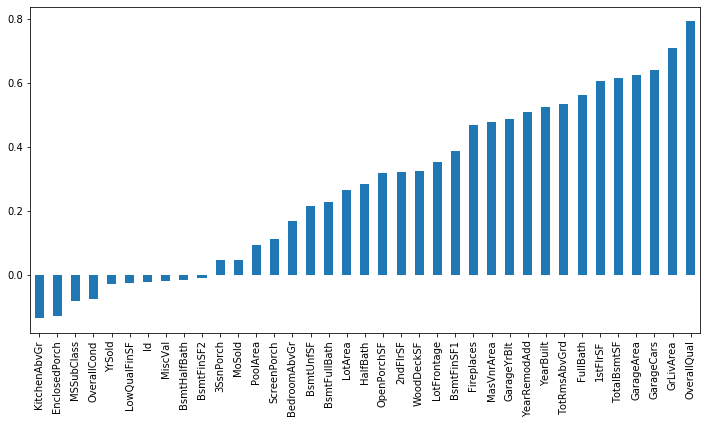

In [7]:
#correlation to SalePrice
plt.figure(figsize=(12,6))
df.corr()['SalePrice'].drop('SalePrice').sort_values().plot(kind='bar')

'OverallQual' and 'GrLivArea' are the strongest predictors for 'SalePrice'

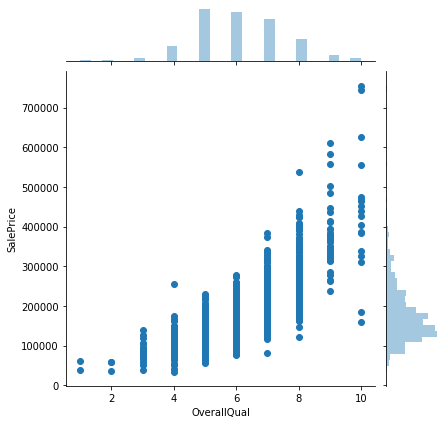

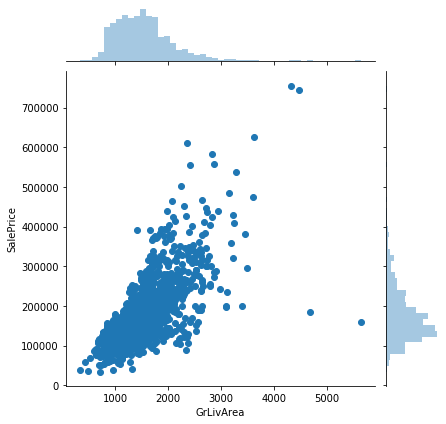

In [8]:
sns.jointplot(x='OverallQual', y='SalePrice', data=df)

sns.jointplot(x='GrLivArea', y='SalePrice', data=df)

<div id="3"> </div>
### 3. Data Preprocessing

<div id="31"> </div>
#### 3-1. Missing Values
* Categorical column with missing values : 23 
* Numerical column with missing values : 11

In [9]:
#23 catergorical columns with missing values
missing_str = features.select_dtypes('object').isnull().sum().sort_values(ascending=False)
missing_str[missing_str>0]

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
GarageCond       159
GarageQual       159
GarageFinish     159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MSZoning           4
Functional         2
Utilities          2
Electrical         1
KitchenQual        1
SaleType           1
Exterior2nd        1
Exterior1st        1
dtype: int64

**Categorical missing filling with 'None':**

From description text file, we know NA represents the properties does not have these facilities like basement, garage, etc. 

In [10]:
fill_none = ['MiscFeature','Alley','Fence','FireplaceQu','GarageType','GarageCond', 'GarageQual','GarageFinish','BsmtCond','BsmtFinType1', 'BsmtFinType2', 'BsmtExposure', 'BsmtQual','MasVnrType']
features[fill_none] = features[fill_none].fillna('None',inplace=False)

**Categorical missing filling with 'N' and making it binary:**

'PoolQC' stands for those properties with 'PoolArea'>0. There are only seven properties with pool regions, so drop 'PoolArea' and represented by 'PoolQC'. Futhermore, 'PoolQC' quality seems to have no effects on final price, so turn it into binary coding.

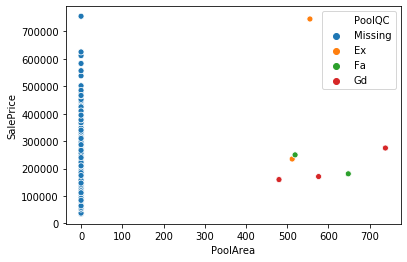

In [11]:
sns.scatterplot(x='PoolArea',y='SalePrice',data=df.fillna('Missing'),hue='PoolQC')

In [12]:
features['PoolQC'].fillna('N',inplace=True)
features['PoolQC'].replace({'Ex':'Y','Fa':'Y','Gd':'Y'},inplace=True)
features.drop('PoolArea',axis=1,inplace=True)

**Categorical missing filling with 'mode':**

The remained categorical columns with only few missing value, and does not represent the facilities are not available in the houses. As a result, the strategy is to fill them with it mode (most occurring value).

In [13]:
otr_cate = ['MSZoning', 'Utilities', 'Functional', 'Electrical', 'SaleType', 'Exterior2nd', 'Exterior1st', 'KitchenQual']
for c in otr_cate:
    features[c] = features[c].fillna(features[c].mode()[0],inplace=False)

In [14]:
#11 catergorical columns with missing values
missing_num = features.select_dtypes(['int64','float64']).isnull().sum().sort_values(ascending=False)
missing_num[missing_num>0]

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtHalfBath      2
BsmtFullBath      2
GarageArea        1
GarageCars        1
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
dtype: int64

**Numerical missing filling with meidan:**

'LotFrontage' is correlated with 'LotArea', so it may not suitable to fill missing value with 'None'.

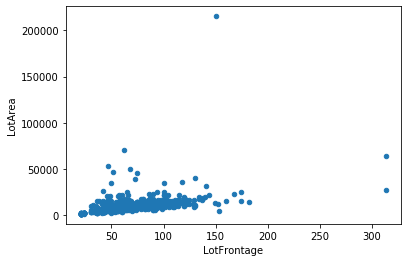

In [15]:
df.plot(x='LotFrontage',y='LotArea',kind='scatter')

In [16]:
features['LotFrontage'].fillna(features['LotFrontage'].median(),inplace=True)

**Numerical missing filling with '0':**

Missing 'GarageYrBlt' means garages are not available in the properties, and other missing value counts are relatively small for other columns, so fill them all with 0 for simplicity.

In [17]:
features[features['GarageCond']=='None']['GarageYrBlt'].isnull().sum()

159

In [18]:
features['GarageYrBlt'].fillna(0,inplace=True)

In [19]:
fill_zero = ['GarageArea','GarageCars','MasVnrArea','BsmtFullBath','BsmtHalfBath','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']
features[fill_zero] = features[fill_zero].fillna(0)

<div id="32"> </div>
#### 3-2. Outliers

Outliers or high leverage points could significantly alter our linear regression, so we have to identify and remove these points from our training set.

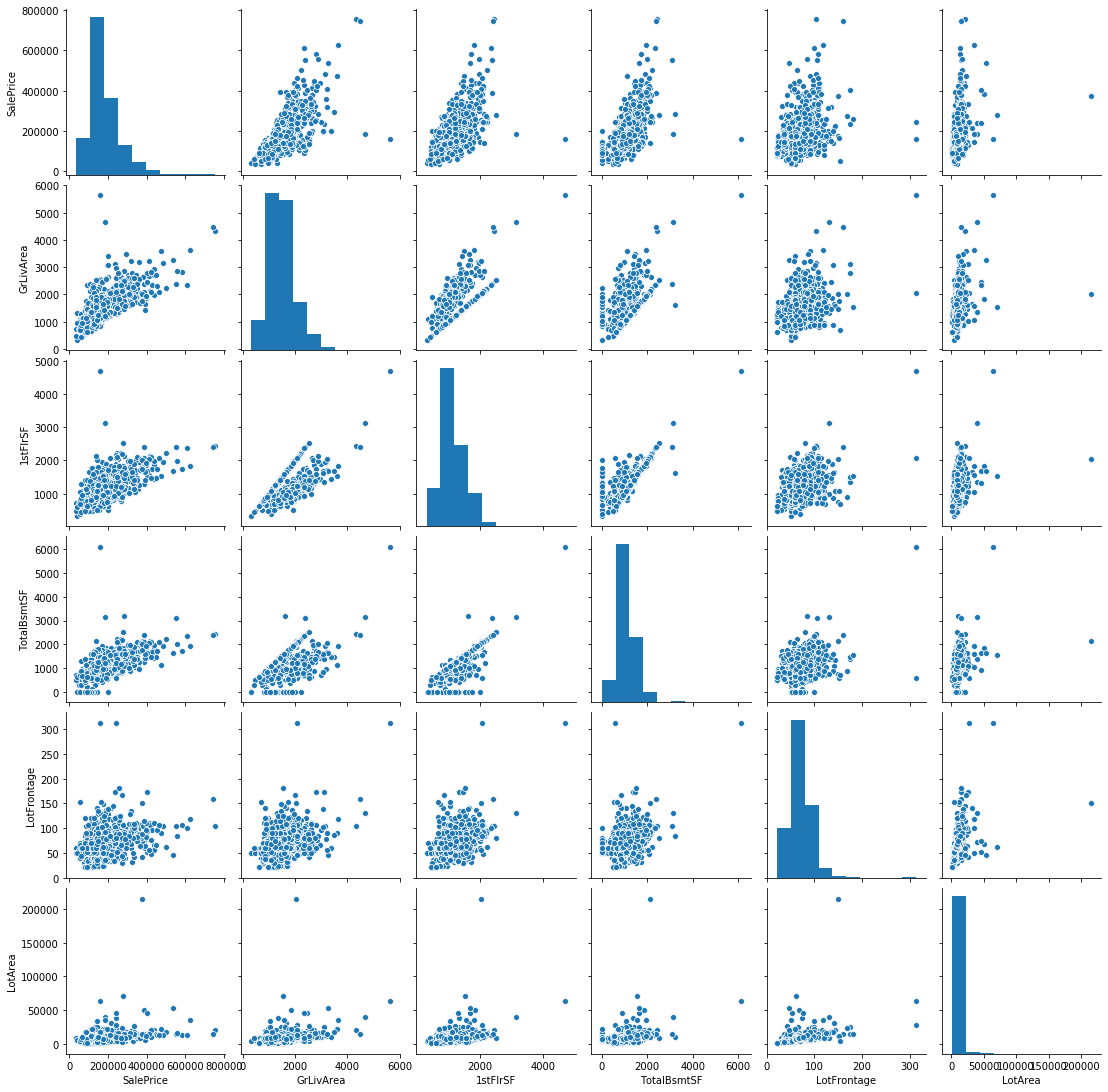

In [20]:
# focusing on first row, and found some point does not follow the trend
sns.pairplot(df[['SalePrice','GrLivArea','1stFlrSF','TotalBsmtSF','LotFrontage','LotArea']].dropna())

Since there are some duplicated outliers, first collect them all and then remove duplicated before drop from dataframe.

In [21]:
drop_index = [] # list to contain all rows should be excluded
drop_index.append(df[(df['GrLivArea']>4500) & (df['SalePrice']<400000)].loc[:train_size].index)
drop_index.append(df[(df['1stFlrSF']>4000) & (df['SalePrice']<400000)].loc[:train_size].index)
drop_index.append(df[(df['TotalBsmtSF']>6000) & (df['SalePrice']<400000)].loc[:train_size].index)
drop_index.append(df[df['LotArea']>100000].index)
drop_index.append(df[df['LotFrontage']>300].index)

drop_index = list(map(list,drop_index)) # IndexObject -> python list
tmp = []
for sublist in drop_index:
    for item in sublist:
        tmp.append(item)
drop_index = list(set(tmp))  # merge into single list and take set() to remove the duplicated

features.drop(drop_index,inplace=True)
target.drop(drop_index,inplace=True)

<div id="33"> </div>
#### 3-3. Column Modification

**'MSSubClass'**: Identifies the type of dwelling involved in the sale.
* 20 : 1-STORY 1946 & NEWER ALL STYLES
* 30 : 1-STORY 1945 & OLDER
* ...

This should be a categorical column, instead of numerical one.

In [22]:
features['MSSubClass'] = features['MSSubClass'].astype('object') 

**'Utilities'**: only one row with different value, so remove this column

In [23]:
features['Utilities'].value_counts()

AllPub    2911
NoSeWa       1
Name: Utilities, dtype: int64

In [24]:
features.drop('Utilities',axis=1,inplace=True)

**'Id**: remove it, because it contains no useful information for price prediction.

In [25]:
features.drop('Id',axis=1,inplace=True)

**'LowQualFinSF'**: transforming into binary variable, since only few observations with value >0, and not sensitive to 'SalePrice'

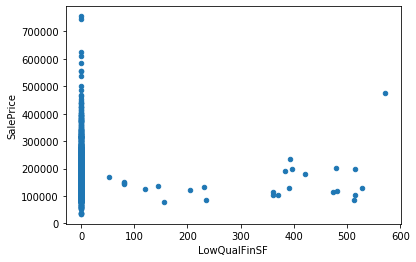

In [26]:
df.plot(x='LowQualFinSF',y='SalePrice',kind='scatter')

In [27]:
features['LowQualFinSF'] = features['LowQualFinSF'].apply(lambda x: 'Y' if x>0 else 'N')

<div id="34"> </div>
#### 3-4. Non-linearity

One of the fundamental assumptions of linear model is that every predictor X is linearly correlated to response Y. Since our response Y will take log transformation to improve the problem that residue variance is related to Y. 

**'GrLivArea'** is the strongest predictor but the linear relationship with 'SalePrice' could be further imporved, by taking square root of 'GrLivArea'.

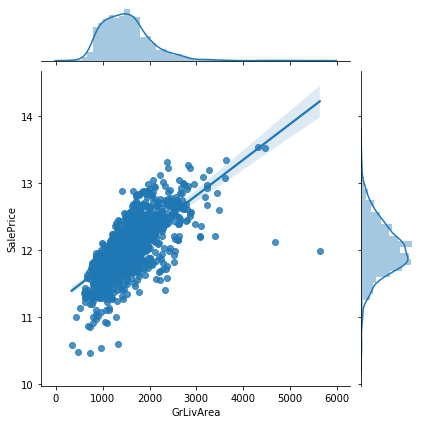

In [28]:
#before take square root
sns.jointplot(x=df['GrLivArea'],y=df['SalePrice'].apply(np.log1p),data=df,kind='reg')

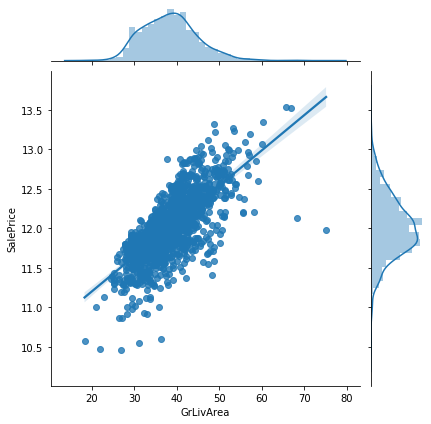

In [29]:
#after take square root
sns.jointplot(x=df['GrLivArea']**0.5,y=df['SalePrice'].apply(np.log1p),data=df,kind='reg')

In [30]:
features['GrLivArea'] = features['GrLivArea']**0.5

<div id="35"> </div>
#### 3-5. Collinearity

Collinearity means any two of the predictors are correlated with each other. This could lead to lower accuracy of the model, because it will be hard to determine the coefficients of each predictor.

In [31]:
#predictor pairwise correlation check
corr_matrix = features.corr()
colinearity = {}
for column in corr_matrix.columns:
    index = corr_matrix[corr_matrix[column]>0.6].index
    for indice in index:
        if not column == indice:
            if not indice+' '+column in colinearity.keys():
                colinearity[column+' '+indice]=corr_matrix.loc[indice,column]
colinearity

{'OverallQual GarageCars': 0.6009002825220063,
 'YearBuilt YearRemodAdd': 0.6125783823934714,
 'BsmtFinSF1 BsmtFullBath': 0.6424797159573521,
 'TotalBsmtSF 1stFlrSF': 0.794348167383102,
 '2ndFlrSF GrLivArea': 0.6518476994140467,
 '2ndFlrSF HalfBath': 0.6110213798223216,
 'GrLivArea FullBath': 0.6485037726715602,
 'GrLivArea TotRmsAbvGrd': 0.8127671787283557,
 'BedroomAbvGr TotRmsAbvGrd': 0.6715492244041413,
 'GarageCars GarageArea': 0.8924862023253198}

In [32]:
high_collinerarity = ['GarageArea','TotRmsAbvGrd','1stFlrSF','2ndFlrSF','BsmtFinSF1','BsmtFinSF2','FullBath']
features = features.drop(high_collinerarity,axis=1)

<div id="36"> </div>
#### 3-6. Encoding
Need to encode categorical variables to dummy variable before model fitting.

In [33]:
categorical_cols = list(features.select_dtypes('object').columns)
dummies = pd.get_dummies(features[categorical_cols],drop_first=True)
features = pd.concat([features.drop(categorical_cols,axis=1),dummies],axis=1)

<div id="4"> </div>
### 4. Modeling and Evaluation

In [34]:
X_train = features.loc[0:train_size-1]
y_train = target
X_test = features.loc[train_size:]

In [35]:
X_train.shape

(1453, 261)

For Linear Regression, we assume that response Y and p predictors $X_i$ followed this form,
$$Y = \beta_0 + \beta_1 X_1 + ... + \beta_1 X_P  + \epsilon$$

and estimate coefficients by using least square method, i.e. minimizing RSS.
$$RSS = \sum_{i=1}^n{(y_i-\hat y_i)^2} = \sum_{i=1}^n{(y_i-\beta_0 - \sum_{j=1}^p{\beta_i x_{ij}})}$$

For Ridge Regression, shrinkage penalty is applied to punish large coefficient by a parameter $\lambda$, resulting in reducing the variance.
$$RSS + \lambda \sum_{i=1}^p{\beta_i^2}$$

This seems to work well, as number of observations n is not significantly large than that of predictors p.

In this database we have only 1453 observations in training dataset, but there are 261 predictors. This may be one of the reasons why it works.

In [36]:
from sklearn.linear_model import RidgeCV
reg = RidgeCV()
reg.fit(X_train,np.log1p(y_train))
#reg.fit(X_train,y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [37]:
from sklearn.model_selection import cross_val_score
log_rms = np.sqrt(-np.mean(cross_val_score(reg, X_train,np.log1p(y_train), cv=5,scoring='neg_mean_squared_error')))
#log_rms = np.sqrt(-np.mean(cross_val_score(reg, X_train,y_train, cv=5,scoring='neg_mean_squared_log_error')))
print(f'RMLS : {log_rms}')

RMLS : 0.11326714902014548


In [38]:
pred = np.expm1(reg.predict(X_train))
#pred = reg.predict(X_train)

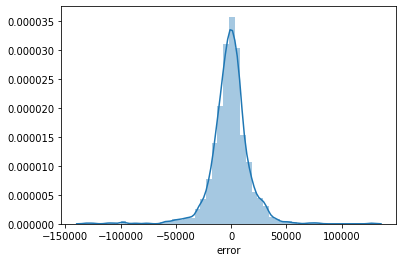

In [39]:
comparison = pd.DataFrame({'prediction':pred.reshape(pred.shape[0],),'actual':y_train,'error':pred.reshape(pred.shape[0],)-y_train})
sns.distplot(comparison['error'])

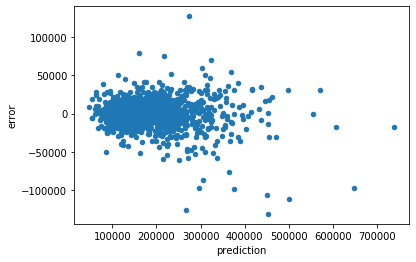

In [40]:
comparison.plot(x='prediction',y='error',kind='scatter')

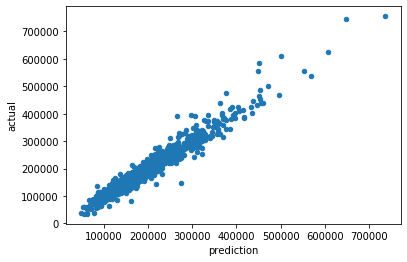

In [41]:
comparison.plot(x='prediction',y='actual',kind='scatter')

In [42]:
# output result for submission
pred = np.expm1(reg.predict(X_test))
pred = pd.DataFrame(pred.reshape(1459, ))
output = pd.concat([df_test['Id'],pred],axis=1).rename(columns={0:'SalePrice'})
output.to_csv(f'submission.csv',index=False)    

<div id="5"> </div>
### 5. Effectiveness of Preprocessing

* cotrol : steps including only handle missing values and encoding (= comment out 3-2~3-5, and log transformation of y)
* Outliers : 3-2
* Log_y : take log transformation of response y
* Modification : 3-3 column modification
* Non-linearity : 3-4 non-linearity
* Collinearity : 3-5 collinearity

Text(0.5, 1.0, 'RMLS Changing wrt to Preprocessing Actions')

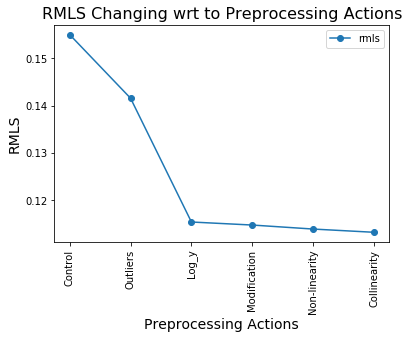

In [43]:
steps = ['Control','Outliers','Log_y','Modification','Non-linearity','Collinearity']
rmls = [0.15494899171649665,0.14154336306738766,0.11543537404168344,0.11479554199015254,0.11394995795225088,0.11326714995779572]
scores = pd.DataFrame({'steps':steps,'rmls':rmls})

scores.plot(x='steps',y='rmls',marker='o',rot=90)
plt.xlabel('Preprocessing Actions',fontsize=14)
plt.ylabel('RMLS',fontsize=14)
plt.title('RMLS Changing wrt to Preprocessing Actions',fontsize=16)